# TRAINING NOTEBOOK

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

import xgboost as xgb

from scipy.signal import find_peaks
from scipy.ndimage.filters import gaussian_filter1d

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# DATA PREPARATION

In [4]:
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [ ]:
# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

In [5]:
# ===== MODEL SAMPLES ======
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')

valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')

test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


In [6]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Ion type list
ion_list = list(np.arange(0,100,1.0))
ion_list.remove(4.0)

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


# FEATURE ENGINEERING

In the benchmark notebook the features are discretized into bins of 100 degrees.

In [7]:
#TODO How long does it take for temperature to rise to certain level where we get abundance?
#TODO How to account for the non-linear diferences of time vs temp?
#TODO Each type of ion as a feature, make a matrix and append to the training dataset
#TODO Max value of abundance of each ion - take temp reading and time - or duration
#TODO How to define characteristic of peaks in ion abundances; temp at which they occur, the shape of peaks (height, width, area)
#TODO How to deal with overlapping peaks
#TODO Number of peaks, size of the peaks
#TODO Can we do some target encoding?

**Compute min and max temp for all available samples, including the ion types**

In [8]:
# Get min/max temperature values and unique ion list
# Preprocess the data to remove noise before calculation
min_temp, max_temp, ion_list = preprocess.compute_min_max_temp_ion(metadata)
print(colored(f'Min temp = {min_temp}; Max temp = {max_temp}', 'blue'))
print(colored(f'Number of unqiue ions: {len(ion_list)}', 'blue'))

100%|██████████| 1570/1570 [01:54<00:00, 13.76it/s]

Min temp = -63.563; Max temp = 1484.13
Number of unqiue ions: 99


## Max relative abundance per temp bin and ion type

Bin the temp from min to max in intervals of 100 degrees and combine with the ion type i.e. `m/z`. For each combination compute the maximum relative abundance.

In [9]:
# ===== TRAIN SAMPLE =====
print(f'Number of all test files: {len(trva_files)}')
fts_maxrelabund_tempion = features.features_iontemp_abun(metadata, trva_files)
print(f'Val-Test features: {fts_maxrelabund_tempion.shape}')
fts_maxrelabund_tempion = fts_maxrelabund_tempion.replace(np.nan, 0)

Number of all test files: 1059
Number of samples: 1059
Val-Test features: (1059, 1584)


In [10]:
# ===== VALID & TEST SAMPLE =====
print(f'Number of all test files: {len(all_test_files)}')
fts_maxrelabund_tempion_VT = features.features_iontemp_abun(metadata, all_test_files)
print(f'Val-Test features: {fts_maxrelabund_tempion_VT.shape}')
fts_maxrelabund_tempion_VT = fts_maxrelabund_tempion_VT.replace(np.nan,0)

Number of all test files: 804
Number of samples: 804
Val-Test features: (804, 1584)


## Duration to max temperature per ion type

Ion types are presented in column, rows are samples and values are time in seconds to max abundance. We should also record at what temperature this happens.

In [13]:
# ===== TRAIN SAMPLE =====
fts_dur_maxabund_ion = features.features_ion_duration_maxtemp(metadata, trva_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')
#TODO Fix the warnings

  9%|▉         | 99/1059 [00:40<06:47,  2.35it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
  9%|▉         | 100/1059 [00:40<06:51,  2.33it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 10%|▉         | 101/1059 [00:41<07:24,  2.16it/s]/Users/itacdonev/Document

Features: (1059, 99)


In [14]:
# ===== VALID & TEST SAMPLE =====
fts_dur_maxabund_ion_VT = features.features_ion_duration_maxtemp(metadata, all_test_files, ion_list)
print(f'Features: {fts_dur_maxabund_ion.shape}')

 12%|█▏        | 99/804 [00:44<05:07,  2.30it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 12%|█▏        | 100/804 [00:45<05:24,  2.17it/s]/Users/itacdonev/Documents/PROJECTS/MarsSpectrometry/src/features.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fts_df[sample_name] = fts_df['m/z'].map(duration_max_abund)
 13%|█▎        | 101/804 [00:45<05:07,  2.28it/s]/Users/itacdonev/Documents/P

Features: (1059, 99)


## Combine mx relative abundance and duration

In [15]:
# ===== TRAIN SAMPLE =====
combo_maxabund_dur = pd.concat([fts_maxrelabund_tempion, fts_dur_maxabund_ion], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur.shape)

(1059, 1683)


In [16]:
# ===== VALID & TEST SAMPLE =====
combo_maxabund_dur_VT = pd.concat([fts_maxrelabund_tempion_VT, fts_dur_maxabund_ion_VT], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_dur_VT.shape)

(804, 1683)


## Analysis of time series

- Percentage change in relative abundance per temp-ion - For each temperature(bin)-ion combination compute the change in relativen abundance.
- find number of peaks
- area under the curve for each ion type

### Hands-On Analysis

- add ion_cnt_peaks
- add time to peak
- first bigger than second if more than one

Refernces:  
- [finding peaks in MS data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- [SO comment on scipy](https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy)

In [ ]:
ht = preprocess.get_sample(metadata,0)
ht = preprocess.preprocess_samples(ht)

In [ ]:
htt = ht[ht['m/z'] == 9.0].copy()
htt['abun_minsub_scaled_filtered'] = gaussian_filter1d(htt['abun_minsub_scaled'], sigma=4)

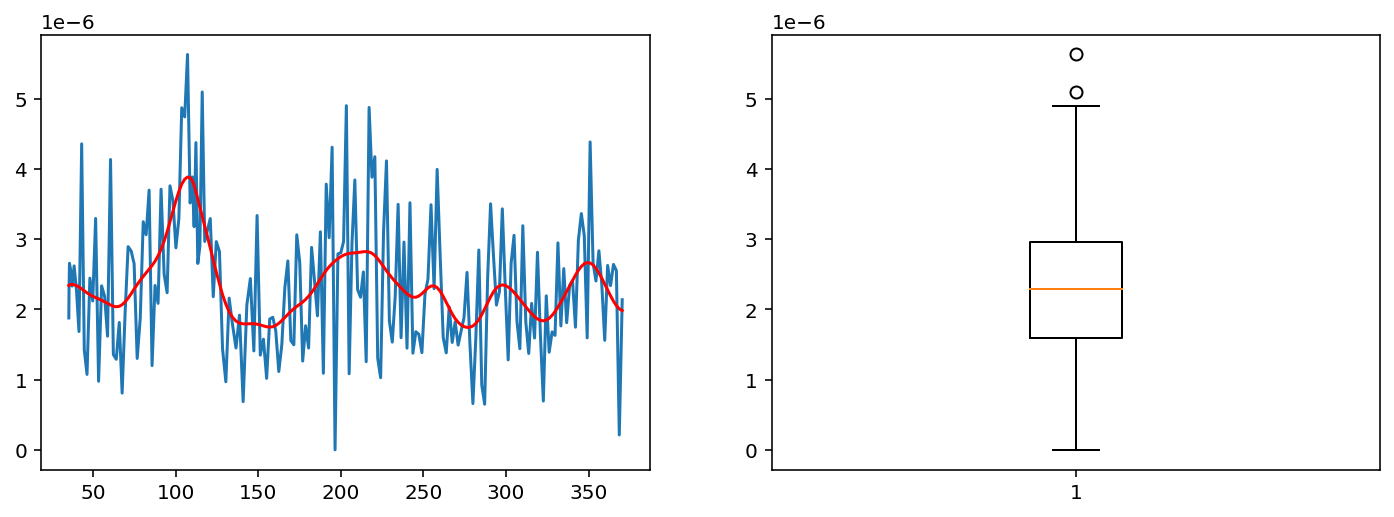

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled'])
plt.subplot(1, 2, 1); plt.plot(htt['temp'], htt['abun_minsub_scaled_filtered'], color='red')
plt.subplot(1, 2, 2); plt.boxplot(htt['abun_minsub_scaled'])
plt.show()

In [ ]:
ion_abund_median = htt['abun_minsub_scaled_filtered'].mean()
print(ion_abund_median)
peaks, _ = find_peaks(htt['abun_minsub_scaled_filtered'], prominence=ion_abund_median)
#peaks_s = find_peaks_cwt(htt['abun_minsub_scaled'], noise_perc=0.1)
print(f'Peak idx: {peaks}') # indexes where peaks are found
#print(f'Peak idx: {peaks_s}') # indexes where peaks are found
# Get temp values for peaks
for i in peaks:
    print(htt.iloc[i]['temp'])
    
# Compute area under the curve
#xx = htt['temp']
#yy = htt['abun_minsub_scaled']
#print(f'Area under the curve: {np.round(auc(xx,yy),5)}')

2.360300874910426e-06
Peak idx: []


In [ ]:
# Computation for sample S0000
ion_peaks_cnt = {}

for ion in ion_list:
    ion_peaks_info = []
    temp_dt = ht[ht['m/z'] == ion].copy()
    temp_dt['abun_minsub_scaled_filtered'] = gaussian_filter1d(temp_dt['abun_minsub_scaled'], 
                                                               sigma=4)
    med = temp_dt['abun_minsub_scaled_filtered'].median()
    
    peaks, _ = find_peaks(temp_dt['abun_minsub_scaled_filtered'], prominence=med)
    ion_peaks_info.append(len(peaks))
    
    peak_temp = []
    peak_time = []
    peak_abund = []
    for i in peaks:
        tm = temp_dt.iloc[i]['time']; peak_time.append(tm) 
        t = temp_dt.iloc[i]['temp']; peak_temp.append(t)
        a = temp_dt.iloc[i]['abun_minsub_scaled']; peak_abund.append(a)
    
    if len(peak_time)>0 and len(peak_temp)>0 and len(peak_abund)>0:
        peak_time = max(peak_time)
        peak_temp = max(peak_temp)
        peak_abund = max(peak_abund)
    else: 
        peak_time, peak_temp, peak_abund = 0, 0, 0
        
    # Compute AUC
    if not temp_dt.empty:
        area_abund = np.round(auc(temp_dt['temp'],temp_dt['abun_minsub_scaled']),5)
    else: area_abund = 0
    
    # Add values
    ion_peaks_info.append(peak_time)
    ion_peaks_info.append(peak_temp)
    ion_peaks_info.append(peak_abund)
    ion_peaks_info.append(area_abund)
        
    ion_peaks_cnt[ion] = ion_peaks_info
    
ion_peaks_cnt

{0.0: [2, 1057.428, 211.921, 0.004470519521099676, 0.23782],
 1.0: [2, 1057.428, 211.921, 0.0038136619698634225, 0.21449],
 2.0: [2, 1077.961, 215.359, 0.0005123556598944679, 0.03806],
 3.0: [0, 0, 0, 0, 0.03961],
 5.0: [1, 441.332, 105.458, 2.7124405884896144e-05, 0.00385],
 6.0: [1, 431.06, 103.666, 2.6798565682232838e-06, 0.00084],
 7.0: [1, 420.772, 101.931, 4.246513336702777e-06, 0.0006],
 8.0: [0, 0, 0, 0, 0.00104],
 9.0: [0, 0, 0, 0, 0.00078],
 10.0: [0, 0, 0, 0, 0.00082],
 11.0: [0, 0, 0, 0, 0.00084],
 12.0: [2, 1796.886, 340.303, 0.00014395089424569068, 0.01731],
 13.0: [0, 0, 0, 0, 0.00402],
 14.0: [0, 0, 0, 0, 0.38302],
 15.0: [2, 1077.961, 215.359, 0.00023548035042686977, 0.01611],
 16.0: [2, 1057.428, 211.921, 0.024268038610332734, 1.2762],
 17.0: [2, 1057.428, 211.921, 0.2731880287813971, 13.32941],
 18.0: [2, 1057.428, 211.921, 0.9858801583853227, 48.16406],
 19.0: [2, 1088.232, 217.115, 0.006349436036159307, 0.46937],
 20.0: [2, 1057.428, 211.921, 0.002035174175259523, 

In [ ]:
new_cols = ['m/z','peak_cnt', 'peak_time', 'peak_temp', 'peak_abund', 'abund_area']
ion_peaks_stats = pd.DataFrame(ion_peaks_cnt)
ion_peaks_stats = ion_peaks_stats.T
ion_peaks_stats.reset_index(inplace=True)
ion_peaks_stats.columns = new_cols
ion_peaks_stats['sample_id'] = 'S0000'
ion_peaks_stats

,m/z,peak_cnt,peak_time,peak_temp,peak_abund,abund_area,sample_id
0,0.0,2.0,1057.428,211.921,0.004471,0.23782,S0000
1,1.0,2.0,1057.428,211.921,0.003814,0.21449,S0000
2,2.0,2.0,1077.961,215.359,0.000512,0.03806,S0000
3,3.0,0.0,0.000,0.000,0.000000,0.03961,S0000
4,5.0,1.0,441.332,105.458,0.000027,0.00385,S0000
...,...,...,...,...,...,...,...
94,95.0,0.0,0.000,0.000,0.000000,0.00049,S0000
95,96.0,0.0,0.000,0.000,0.000000,0.00074,S0000
96,97.0,0.0,0.000,0.000,0.000000,0.00052,S0000
97,98.0,0.0,0.000,0.000,0.000000,0.00050,S0000


In [ ]:
features.compute_ion_peaks(metadata, 0, ion_list)

peak_cnt                                               ...  \
m/z           0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0  ...   
sample_id                                                        ...   
S0000          2.0  2.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  ...   

          peak_abund                                               
m/z             90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0  
sample_id                                                          
S0000            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 396 columns]

In [ ]:
file_paths = {A:N for (A,N) in [x for x in train_files.items()][:5]}
ita = features.features_ion_peaks(file_paths, metadata, ion_list)
ita

peak_cnt                                               ...  \
m/z           0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0  ...   
sample_id                                                        ...   
S0000          2.0  2.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  ...   
S0001          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
S0002          1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...   
S0003          1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  3.0  ...   
S0004          2.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...   

          peak_abund                                               
m/z             90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0  
sample_id                                                          
S0000            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0001            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0002            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0003            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
S0004            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 396 columns]

### Abundance Peaks + Stats

In [17]:
# ===== TRAIN SAMPLE =====
fts_ion_peaks = features.features_ion_peaks(trva_files, metadata, ion_list)
print(fts_ion_peaks.shape)
fts_ion_peaks.head()

100%|██████████| 1059/1059 [04:25<00:00,  3.99it/s]

(1059, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,2.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0003,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0004,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# ===== VALID & TEST SAMPLE =====
fts_ion_peaks_VT = features.features_ion_peaks(all_test_files, metadata, ion_list)
print(fts_ion_peaks_VT.shape)
fts_ion_peaks_VT.head()

100%|██████████| 804/804 [03:56<00:00,  3.40it/s]

(804, 396)


,peak_cnt_0.0,peak_cnt_1.0,peak_cnt_2.0,peak_cnt_3.0,peak_cnt_5.0,peak_cnt_6.0,peak_cnt_7.0,peak_cnt_8.0,peak_cnt_9.0,peak_cnt_10.0,...,peak_abund_90.0,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0769,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S0770,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**ANALYZE THE ABUNDANCE CURVE**

## Combine mx relative abundance and ion peaks

In [19]:
# ===== TRAIN SAMPLE =====
combo_maxabund_peaks = pd.concat([fts_maxrelabund_tempion, fts_ion_peaks], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_peaks.shape)

(1059, 1980)


In [20]:
# ===== VALID & TEST SAMPLE =====
combo_maxabund_peaks_VT = pd.concat([fts_maxrelabund_tempion_VT, fts_ion_peaks_VT], 
                               axis = 1, 
                               ignore_index=False)
print(combo_maxabund_peaks_VT.shape)

(804, 1980)


# MODELS

In [21]:
# Data frame to save local CV results
models_log_loss = pd.DataFrame(index=target_labels_list)

## Logistic Regression - Benchmark

In [22]:
# ===== TRAIN MODEL - CROSS VALIDATION =====
clf = LogisticRegression(penalty="l1",solver="liblinear", 
                         C=10, random_state=config.RANDOM_SEED)
logloss_LR = training.trainCV_label(X = fts_maxrelabund_tempion, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['LRbench'] = models_log_loss.index.map(logloss_LR)

# Print results
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_LR.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_LR

Average Log Loss: 0.2602
Log Loss per Label:


{'basalt': 0.26152610421079714,
 'carbonate': 0.22292052739226142,
 'chloride': 0.25846765369554403,
 'iron_oxide': 0.37216113777027066,
 'oxalate': 0.004914672949143167,
 'oxychlorine': 0.2526301582566911,
 'phyllosilicate': 0.4112433512412358,
 'silicate': 0.3498702145055753,
 'sulfate': 0.3228680540360762,
 'sulfide': 0.1453285461910574}

In [23]:
# ===== TRAIN FULL MODEL ===== 
clf_LRr = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'LR')

In [24]:
# ===== PREDICT SUBMISSION =====
submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_LRr:
    clf = clf_LRr[target]
    submission[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission.to_csv(config.MODELS_DIR + 'LRr_trvl.csv')

submission.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,1.478012e-09,0.000004,9.389665e-07,0.000049,0.000009,0.031049,5.315916e-08,0.309314,0.000008,7.589440e-07
S0767,1.067875e-01,0.100124,3.911715e-03,0.188425,0.000038,0.186541,1.228418e-02,0.805024,0.037436,5.259259e-03
S0768,6.141123e-01,0.413942,1.546588e-04,0.155942,0.000425,0.229898,8.210618e-01,0.692529,0.304117,1.988193e-03
S0769,9.150200e-03,0.032347,6.204545e-02,0.081357,0.000025,0.972955,8.624104e-02,0.047278,0.542596,2.910994e-03
S0770,1.470720e-03,0.006570,6.099042e-02,0.282994,0.000180,0.810249,5.878457e-01,0.004328,0.004787,1.021201e-02


## XGBoost

- numerical data needs to be scaled
- categorical data needs to be encoded

In [59]:
params = {
    'n_estimators': 100,
    #'max_depth': 5
    #'learning_rate': 0.09
}

In [60]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        params=params)
logloss_XGB = training.trainCV_label(X = fts_maxrelabund_tempion, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost'] = models_log_loss.index.map(logloss_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:23:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:23:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:24:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:25:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:26:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:27:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:29:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:30:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [61]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB

Average Log Loss: 0.1603
Log Loss per Label:


{'basalt': 0.17535642713573033,
 'carbonate': 0.09042970225928271,
 'chloride': 0.18622434858380826,
 'iron_oxide': 0.23514644413808328,
 'oxalate': 0.017460904940602717,
 'oxychlorine': 0.16719442244347366,
 'phyllosilicate': 0.2574618023465163,
 'silicate': 0.20515629972326366,
 'sulfate': 0.18776378520666673,
 'sulfide': 0.08088348573694427}

In [62]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                                    params=params)

# ===== PREDICT SUBMISSION =====
submission_xgb = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb.to_csv(config.MODELS_DIR + 'XGB_trvl.csv')

submission_xgb.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000893,0.000721,0.001090,0.000492,0.000845,0.000953,0.002652,0.021751,0.001149,0.000748
S0767,0.002988,0.000819,0.000169,0.000974,0.000356,0.000579,0.004814,0.012331,0.001026,0.000088
S0768,0.991968,0.010956,0.000119,0.004674,0.000871,0.001058,0.985172,0.997009,0.009200,0.000098
S0769,0.000750,0.000337,0.008155,0.002661,0.000356,0.994784,0.002609,0.000323,0.994576,0.000404
S0770,0.000309,0.000205,0.001046,0.982295,0.001090,0.999413,0.998096,0.000205,0.000507,0.000096


## XGBoost - optimized
- numerical data needs to be scaled
- categorical data needs to be encoded

In [63]:
#TODO Finish
params_opt = {
    #'n_estimators': 150,
    #'max_depth': 5
    'learning_rate': 0.09
}

In [64]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        **params_opt)
logloss_XGBopt = training.trainCV_label(X = fts_maxrelabund_tempion,
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_opt'] = models_log_loss.index.map(logloss_XGBopt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [65]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGBopt.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGBopt

Average Log Loss: 0.1493
Log Loss per Label:


{'basalt': 0.16030390276618628,
 'carbonate': 0.09299784144611556,
 'chloride': 0.17099937928281922,
 'iron_oxide': 0.2110446946926557,
 'oxalate': 0.016176140634807434,
 'oxychlorine': 0.15975673521358977,
 'phyllosilicate': 0.2392929120695717,
 'silicate': 0.18674152896437207,
 'sulfate': 0.17355651791774612,
 'sulfide': 0.08166643602891402}

In [66]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_maxrelabund_tempion,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                                    params=params_opt)

# ===== PREDICT SUBMISSION =====
submission_xgb_opt = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_opt[target] = clf.predict_proba(fts_maxrelabund_tempion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_opt.to_csv(config.MODELS_DIR + 'XGBopt_trvl.csv')

submission_xgb_opt.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.002441,0.001563,0.007935,0.002448,0.000915,0.003622,0.006410,0.052359,0.002399,0.001250
S0767,0.009165,0.004936,0.001804,0.005228,0.000471,0.002397,0.011200,0.043701,0.005525,0.000510
S0768,0.973192,0.027186,0.000792,0.009643,0.001062,0.007589,0.927079,0.986137,0.014394,0.000767
S0769,0.002433,0.001187,0.013194,0.014279,0.000471,0.983513,0.009265,0.001311,0.973285,0.001605
S0770,0.001844,0.001195,0.004320,0.924464,0.001212,0.994040,0.985272,0.000837,0.003188,0.000632


## XGBoost - duration

In [32]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        params=params)
logloss_XGB_dur = training.trainCV_label(X = fts_dur_maxabund_ion, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_dur'] = models_log_loss.index.map(logloss_XGB_dur)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [33]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB_dur.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB_dur

Average Log Loss: 0.273
Log Loss per Label:


{'basalt': 0.3055408407851914,
 'carbonate': 0.22551929952974864,
 'chloride': 0.2966949526008073,
 'iron_oxide': 0.3625905167427778,
 'oxalate': 0.039618770175165,
 'oxychlorine': 0.26038114680724184,
 'phyllosilicate': 0.40699815883580276,
 'silicate': 0.39327534644349155,
 'sulfate': 0.3002615824871525,
 'sulfide': 0.13873472183943675}

In [34]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = fts_dur_maxabund_ion,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                                    params=params)

# ===== PREDICT SUBMISSION =====
submission_xgb_dur = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_dur[target] = clf.predict_proba(fts_dur_maxabund_ion_VT)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_dur.to_csv(config.MODELS_DIR + 'XGB_dur_trvl.csv')

submission_xgb_dur.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.001810,0.000708,0.001024,0.001387,0.000558,0.002520,0.008662,0.014868,0.001133,0.000479
S0767,0.009402,0.000473,0.000495,0.000259,0.000453,0.003253,0.004567,0.007434,0.001176,0.002270
S0768,0.978182,0.010618,0.004406,0.005709,0.000464,0.000714,0.988445,0.994520,0.004672,0.005114
S0769,0.001562,0.002548,0.008439,0.010595,0.000358,0.965493,0.000219,0.001676,0.995098,0.000144
S0770,0.000253,0.000218,0.002347,0.988320,0.000241,0.999366,0.995947,0.000260,0.000075,0.000082


## XGBoost - combo

In [35]:
dt_train = combo_maxabund_dur.copy()
dt_test = combo_maxabund_dur_VT.copy()

In [36]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        params=params)
logloss_XGB_combo = training.trainCV_label(X = dt_train, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_combo'] = models_log_loss.index.map(logloss_XGB_combo)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [37]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB_combo.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB_combo

Average Log Loss: 0.1809
Log Loss per Label:


{'basalt': 0.20060620669789583,
 'carbonate': 0.1291939276937898,
 'chloride': 0.20940846064855684,
 'iron_oxide': 0.25071506613708694,
 'oxalate': 0.017589946185299167,
 'oxychlorine': 0.16455075634466695,
 'phyllosilicate': 0.28584363455497164,
 'silicate': 0.24743590151440342,
 'sulfate': 0.2221172861717001,
 'sulfide': 0.08120631611938726}

In [38]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = dt_train,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                        params=params)

# ===== PREDICT SUBMISSION =====
submission_xgb_combo = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_combo[target] = clf.predict_proba(dt_test)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_combo.to_csv(config.MODELS_DIR + 'XGB_combo_trvl.csv')

submission_xgb_combo.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000782,0.000474,0.001026,0.002535,0.000605,0.000969,0.008051,0.019034,0.001511,0.000466
S0767,0.006182,0.001743,0.000133,0.001053,0.000388,0.001970,0.006853,0.009523,0.001636,0.000372
S0768,0.992395,0.014481,0.000696,0.002810,0.000750,0.000792,0.989180,0.997433,0.003909,0.000259
S0769,0.000090,0.000142,0.004338,0.004442,0.000388,0.989556,0.000145,0.000267,0.998051,0.000228
S0770,0.000101,0.000159,0.001945,0.983329,0.001191,0.998673,0.999038,0.000355,0.000276,0.000247


## XGBoost - Ion peaks

In [39]:
dt_train = fts_ion_peaks.copy()
dt_test = fts_ion_peaks_VT.copy()

In [40]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        params=params)
logloss_XGB_peaks = training.trainCV_label(X = dt_train, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_peaks'] = models_log_loss.index.map(logloss_XGB_peaks)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [41]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(logloss_XGB_peaks.values())), 4)}', 'blue'))
print('Log Loss per Label:')
logloss_XGB_peaks

Average Log Loss: 0.1943
Log Loss per Label:


{'basalt': 0.20015686265739135,
 'carbonate': 0.1542607379512583,
 'chloride': 0.210642844399497,
 'iron_oxide': 0.2844758901330894,
 'oxalate': 0.017206970622709643,
 'oxychlorine': 0.19262451272590778,
 'phyllosilicate': 0.304494001979707,
 'silicate': 0.2697856151071242,
 'sulfate': 0.22948067226818586,
 'sulfide': 0.07983493108521973}

In [42]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = dt_train,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                        params=params)

# ===== PREDICT SUBMISSION =====
submission_xgb_peaks = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_peaks[target] = clf.predict_proba(dt_test)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_peaks.to_csv(config.MODELS_DIR + 'XGB_peaks_trvl.csv')

submission_xgb_peaks.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000568,0.000759,0.001721,0.002421,0.000390,0.001308,0.042694,0.043684,0.000841,0.000190
S0767,0.000582,0.000413,0.000161,0.000314,0.000390,0.000256,0.000599,0.002739,0.000258,0.001160
S0768,0.979509,0.030592,0.001403,0.020338,0.001567,0.000484,0.969208,0.987497,0.026335,0.000197
S0769,0.000076,0.000537,0.004673,0.008913,0.000390,0.998297,0.002261,0.000225,0.974208,0.000485
S0770,0.000700,0.000590,0.003165,0.964625,0.000465,0.997128,0.999248,0.000163,0.000071,0.000620


## XGBoost - Temp bin + Ion peaks

In [43]:
dt_train = combo_maxabund_peaks.copy()
dt_test = combo_maxabund_peaks_VT.copy()

In [44]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        params=params)
combo_maxabund_peaks_XGB = training.trainCV_label(X = dt_train, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_combo_maxpeakd'] = models_log_loss.index.map(combo_maxabund_peaks_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [45]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(combo_maxabund_peaks_XGB.values())), 4)}', 'blue'))
print('Log Loss per Label:')
combo_maxabund_peaks_XGB

Average Log Loss: 0.1553
Log Loss per Label:


{'basalt': 0.16356238449301208,
 'carbonate': 0.0941873047787369,
 'chloride': 0.1783889245653548,
 'iron_oxide': 0.219472295706255,
 'oxalate': 0.013916253853865534,
 'oxychlorine': 0.16610640189249298,
 'phyllosilicate': 0.24581355818453582,
 'silicate': 0.21656403755924045,
 'sulfate': 0.18038265964044645,
 'sulfide': 0.0741848456629162}

In [46]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = dt_train,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                        params=params)

# ===== PREDICT SUBMISSION =====
submission_xgb_combo_maxabund_peaks = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_combo_maxabund_peaks[target] = clf.predict_proba(dt_test)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_combo_maxabund_peaks.to_csv(config.MODELS_DIR + 'XGB_combo_maxabund_peaks_trvl.csv')

submission_xgb_combo_maxabund_peaks.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000533,0.001200,0.001343,0.000855,0.000521,0.000507,0.000974,0.031276,0.000650,0.000398
S0767,0.006159,0.000835,0.000052,0.000782,0.000521,0.000552,0.003931,0.009241,0.001300,0.000080
S0768,0.996562,0.011165,0.000086,0.003226,0.000939,0.001783,0.985910,0.998436,0.007787,0.000213
S0769,0.000182,0.000145,0.002476,0.005076,0.000784,0.995553,0.001986,0.000269,0.993781,0.000251
S0770,0.000341,0.000390,0.003132,0.975408,0.000784,0.999438,0.997612,0.000084,0.000206,0.000154


## XGBoost opt - Temp bin + Ion peaks

In [49]:
dt_train = combo_maxabund_peaks.copy()
dt_test = combo_maxabund_peaks_VT.copy()

In [51]:
# Train the model
clf = xgb.XGBClassifier(objective = "binary:logistic",
                        use_label_encoder = False,
                        eval_metric = 'logloss',
                        **params_opt)
combo_maxabund_peaks_XGB_opt = training.trainCV_label(X = dt_train, 
                                 df_y = trvl_labels, 
                                 target = target_labels_list, 
                                 cv_folds = 10, 
                                 model_metric = log_loss, 
                                 clf = clf)

models_log_loss['XGBoost_combo_maxpeakd_opt'] = models_log_loss.index.map(combo_maxabund_peaks_XGB_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

In [52]:
print(colored(f'Average Log Loss: {np.round(np.mean(list(combo_maxabund_peaks_XGB_opt.values())), 4)}', 'blue'))
print('Log Loss per Label:')
combo_maxabund_peaks_XGB_opt

Average Log Loss: 0.145
Log Loss per Label:


{'basalt': 0.1498281400392832,
 'carbonate': 0.09301901140051114,
 'chloride': 0.16665983013362626,
 'iron_oxide': 0.20769608078810645,
 'oxalate': 0.014033538995205336,
 'oxychlorine': 0.148409597606228,
 'phyllosilicate': 0.22877625417536848,
 'silicate': 0.19691387258807694,
 'sulfate': 0.17159940715849445,
 'sulfide': 0.07329880544762327}

In [ ]:
# ===== TRAIN FULL MODEL ===== 
clf_XGB = training.train_full_model(X = dt_train,
                                    df_y = trvl_labels,
                                    target = target_labels_list,
                                    model_algo = 'XGB',
                                    params=params_opt)

# ===== PREDICT SUBMISSION =====
submission_xgb_combo_maxabund_peaks = pd.read_csv(config.DATA_DIR + 'submission_format.csv', index_col='sample_id')
for target in clf_XGB:
    clf = clf_XGB[target]
    submission_xgb_combo_maxabund_peaks[target] = clf.predict_proba(dt_test)[:,1]

# ===== SAVE SUBMISSION ===== 
submission_xgb_combo_maxabund_peaks.to_csv(config.MODELS_DIR + 'XGB_combo_maxabund_peaks_trvl.csv')

submission_xgb_combo_maxabund_peaks.head()

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.000533,0.001200,0.001343,0.000855,0.000521,0.000507,0.000974,0.031276,0.000650,0.000398
S0767,0.006159,0.000835,0.000052,0.000782,0.000521,0.000552,0.003931,0.009241,0.001300,0.000080
S0768,0.996562,0.011165,0.000086,0.003226,0.000939,0.001783,0.985910,0.998436,0.007787,0.000213
S0769,0.000182,0.000145,0.002476,0.005076,0.000784,0.995553,0.001986,0.000269,0.993781,0.000251
S0770,0.000341,0.000390,0.003132,0.975408,0.000784,0.999438,0.997612,0.000084,0.000206,0.000154


***

***

## Model Summary

- Can we do different models per different target?

In [67]:
models_log_loss.style.highlight_min(axis=1, props='color:darkblue; background-color:lightblue;')

,LRbench,XGBoost,XGBoost_dur,XGBoost_combo,XGBoost_peaks,XGBoost_combo_maxpeakd,XGBoost_combo_maxpeakd_opt,XGBoost_opt
basalt,0.261526,0.175356,0.305541,0.200606,0.200157,0.163562,0.149828,0.160304
carbonate,0.222921,0.090430,0.225519,0.129194,0.154261,0.094187,0.093019,0.092998
chloride,0.258468,0.186224,0.296695,0.209408,0.210643,0.178389,0.166660,0.170999
iron_oxide,0.372161,0.235146,0.362591,0.250715,0.284476,0.219472,0.207696,0.211045
oxalate,0.004915,0.017461,0.039619,0.017590,0.017207,0.013916,0.014034,0.016176
oxychlorine,0.252630,0.167194,0.260381,0.164551,0.192625,0.166106,0.148410,0.159757
phyllosilicate,0.411243,0.257462,0.406998,0.285844,0.304494,0.245814,0.228776,0.239293
silicate,0.349870,0.205156,0.393275,0.247436,0.269786,0.216564,0.196914,0.186742
sulfate,0.322868,0.187764,0.300262,0.222117,0.229481,0.180383,0.171599,0.173557
sulfide,0.145329,0.080883,0.138735,0.081206,0.079835,0.074185,0.073299,0.081666


In [68]:
models_log_loss.agg('mean').sort_values()

XGBoost_combo_maxpeakd_opt    0.145023
XGBoost_opt                   0.149254
XGBoost_combo_maxpeakd        0.155258
XGBoost                       0.160308
XGBoost_combo                 0.180867
XGBoost_peaks                 0.194296
LRbench                       0.260193
XGBoost_dur                   0.272962
dtype: float64